<a href="https://colab.research.google.com/github/LJDrakeley/Drone_Pilot/blob/main/imageAnalysis/SAM_testing_GC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
#Using Google Colab in order to use GPUs and lower runtime. Need to install all relevant packages.
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

  Preparing metadata (setup.py) ... done


In [5]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [6]:
!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

In [7]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


In [11]:
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
import torch
import supervision as sv
from google.colab import files

In [20]:
#Using Google Colab. Need to upload relevant files from local device.
image = files.upload()

In [19]:
# Read the image
#Note that the original file contains an Alpha dimension/channel, however our method of opening the file does not include it.
#Alpha dimension is not needed nor supported by

#Depending on what you are running this code on, the following will change.
image_bgr = cv2.imread("/content/BM-601-0GyV-26wk-4x-2.tif")
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

image_bgr.shape

(2048, 2048, 3)

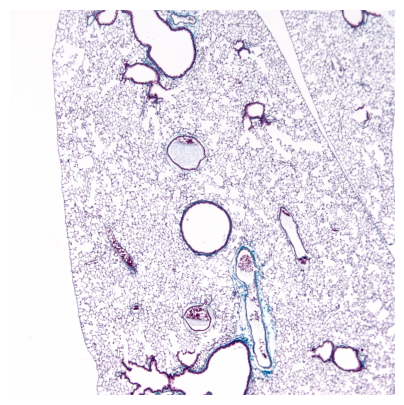

In [24]:
#Show image
plt.figure(figsize=(5, 5))
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

In [36]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [26]:
%%capture
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

In [27]:
mask_generator_ = SamAutomaticMaskGenerator(model=sam)

In [31]:
%%time
#generates a list of dictionaries
results = mask_generator_.generate(image_rgb)

CPU times: user 7.12 s, sys: 95.5 ms, total: 7.22 s
Wall time: 11 s


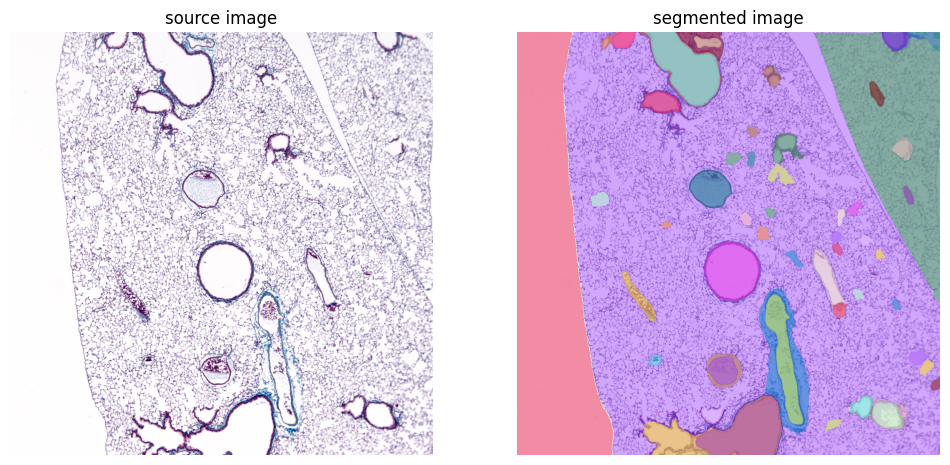

In [32]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=results)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

In [33]:
masks = [mask['segmentation'] for mask in sorted(results, key=lambda x: x['area'], reverse=True)]

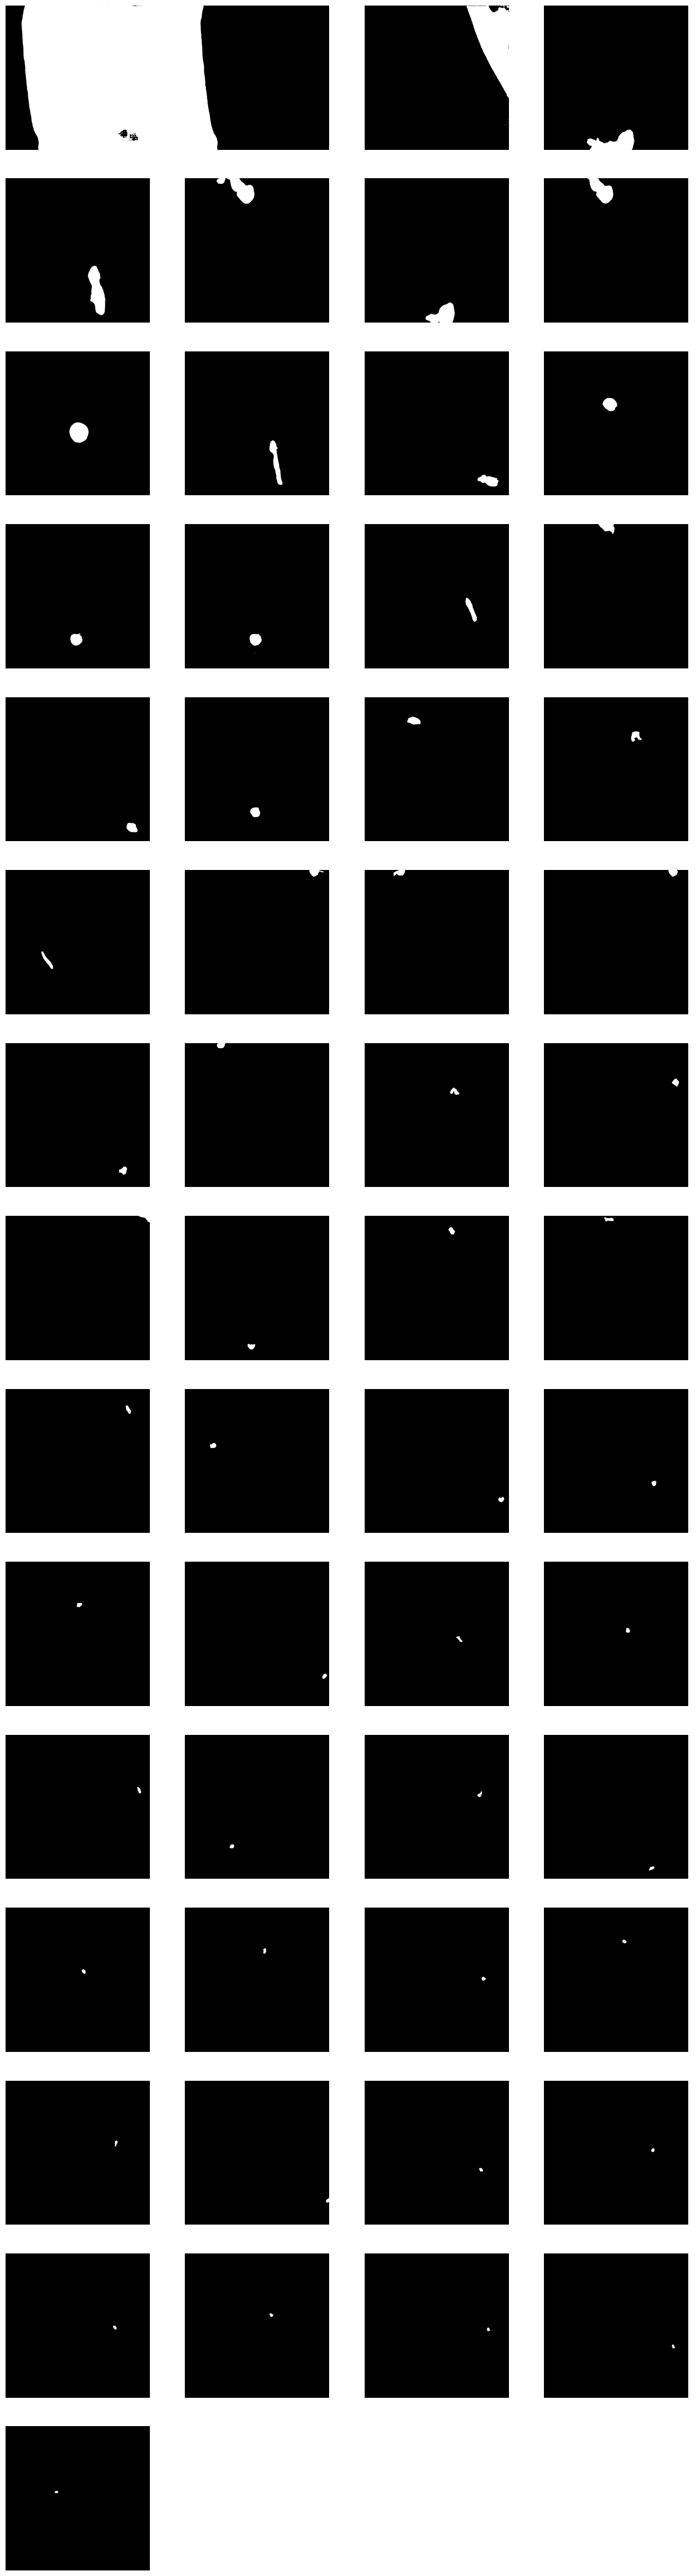

In [44]:
grid_length = math.ceil(len(masks)/4)

sv.plot_images_grid(images=masks,
                    grid_size = (math.ceil(len(masks)/4), 4),
                    size=(16,grid_length*4)
                    )